<a href="https://colab.research.google.com/github/anniemoriondo/cs480student/blob/main/06/Moriondo_CS480_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

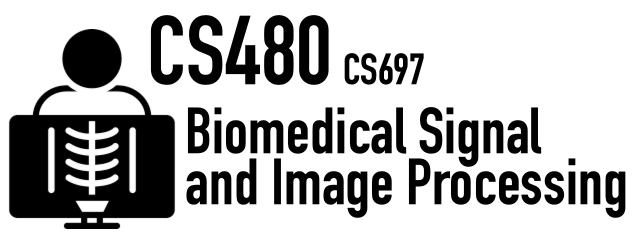
#Assignment 6

In [4]:
# In this assignment, we will train a U-Net classifer to detect mitochondria
# in electron microscopy images!

In [5]:
### IMPORTANT ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
# Thanks - done!
#
### IMPORTANT ###

In [6]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-a03qtg77
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-a03qtg77
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25658 sha256=f076fb677921759504f736a7a701ad981fee5de8799776c338e98a17a77c8c59
  Stored in directory: /tmp/pip-ephem-wheel-cache-21nxcunb/wheels/f5/38/c8/8f0a157cfd7616cc1a24811a52b9a669c0ee8fccc9f99d3cbc
Successfully built unet


In [8]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!
import unet

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

In [9]:
# The unet package allows to train a U-Net classifier with little code.
# As discussed in class, the U-Net can be used to label/segment/annotate images.

In [10]:
# TODO: Please study the Circles example 
# https://github.com/jakeret/unet/blob/master/notebooks/circles.ipynb

In [11]:
# TODO: ... and look how the (artificial) dataset is generated
# https://github.com/jakeret/unet/blob/master/src/unet/datasets/circles.py

In [12]:
# 1) Question
# TODO: Please describe what the U-Net is trained to do.
#
# TODO: YOUR ANSWER
# The U-Net is an artificial neural net which is trained on a set of source data
# and corresponding target data, until it can predict target data based on
# a fresh set of source data. In this case, the source data is randomly
# generated, noisy images of circles, and the target data is "masks" consisting
# of black-and-white regions showing the actual positions of the circles.
# The U-Net, in this case, takes noisy images and tries to predict the masks.

In [13]:
# 2) Question
# TODO: In circles.py, what does the following mean:
#     channels = 1
#     classes = 2
#
# TODO: YOUR ANSWER
# These are the `channels` and `classes` parameters which will be passed to
# `unet` when the U-Net is trained on the images and masks.
# As far as I can tell, channels = 1 means there's one source of data,
# namely circles.py, and classes=2 means that this channel contains two
# classes of data: source data (images) and target data(masks).

In [14]:
# 3) Question
# TODO: What are mitochondria and what is their appearance in
# electron microscopy data?
# Hint: You can validate your answer in Task 4!
#
# TODO: YOUR ANSWER
# Mitochondria are organelles which supply animal cells with energy. They
# appear as oval shapes with the points rounded off, in electron microscopy 
# data.

**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [15]:
# TODO: 
# Download https://cs480.org/data/mito.npz to your computer.
# Then, please upload mito.npz using the file panel on the left.

In [16]:
# The code below is similar to the circles.py file from Task 1.
# We follow Tensorflow conventions to design a tf.data.Dataset for training
# the U-Net.
#
# TODO: Please add four different data augmentation methods in the code block
# below. (image normalization to 0..1, horizontal data flip, vertical data flip,
# rotation by 90 degrees)
#
# Hint: https://github.com/jakeret/unet/blob/master/src/unet/datasets/oxford_iiit_pet.py#L25

# I also consulted the docs at https://www.tensorflow.org
# focusing on the Python API https://www.tensorflow.org/api_docs/python/

In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List

IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    loaded = np.load('mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        #
        # TODO: Normalize the image to 0..1
        #

        # Change the image from a 0...255 scale to 0...1
        image = tf.cast(image, tf.float32) / 255.0
        mask -= 1

        #
        # TODO: Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)

        #
        # TODO: Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)

        #
        # TODO: Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:
            # Specifically, a counterclockwise rotation
            image = tf.image.rot90(image)
            mask = tf.image.rot90(mask)


        # augmentation done, let's store the image
        images[i] = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

    return images, labels

**Task 3**: Let's train the U-Net! [25 Points]

In [18]:
#
# We can now create our training, validation, and testing data by calling
# our methods from Task 2.
#
train, val, test = load_data( 660, splits=(0.7, 0.2, 0.1) )

In [26]:
# 1) Question
# TODO: We have in total 660 images + 660 masks. Based on the code above,
# how many images are used for training alone?
#
# TODO: YOUR ANSWER
print(.7 * 660)
# 462 images are used for training alone.

461.99999999999994


In [27]:
#
# Let's setup the U-Net!
#
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [28]:
#
# And, let's setup the trainer...
#
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [29]:
#
# ...and train the U-Net for 50 epochs with a batch_size of 10!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use training and validation data.
# Hint 2: This will take roughly 30 minutes!
#
trainer.fit(unet_model, train, val, epochs=50, batch_size=10            )

Epoch 1/50
47/47 [==============================] - 59s 1s/step - loss: 0.5231 - categorical_crossentropy: 0.5231 - categorical_accuracy: 0.5014 - mean_iou: 0.2771 - dice_coefficient: 0.5598 - auc: 0.7733 - val_loss: 0.4128 - val_categorical_crossentropy: 0.4128 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3107 - val_dice_coefficient: 0.6262 - val_auc: 0.9936
Epoch 2/50
47/47 [==============================] - 39s 822ms/step - loss: 0.1136 - categorical_crossentropy: 0.1136 - categorical_accuracy: 0.9210 - mean_iou: 0.4144 - dice_coefficient: 0.8525 - auc: 0.9716 - val_loss: 0.1956 - val_categorical_crossentropy: 0.1956 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3881 - val_dice_coefficient: 0.7889 - val_auc: 0.9942
Epoch 3/50
47/47 [==============================] - 39s 832ms/step - loss: 0.0632 - categorical_crossentropy: 0.0632 - categorical_accuracy: 0.9210 - mean_iou: 0.4350 - dice_coefficient: 0.8968 - auc: 0.9789 - val_loss: 0.1046 - val_categorical_crossentropy

**Task 4**: Let's predict mitochondria in the testing data! [15 Points]

In [ ]:
# 
# After training, let's try the U-Net on our testing data.
#
# The code below displays the first 10 input images, the original masks by experts, 
# and the predicted masks from the U-Net.

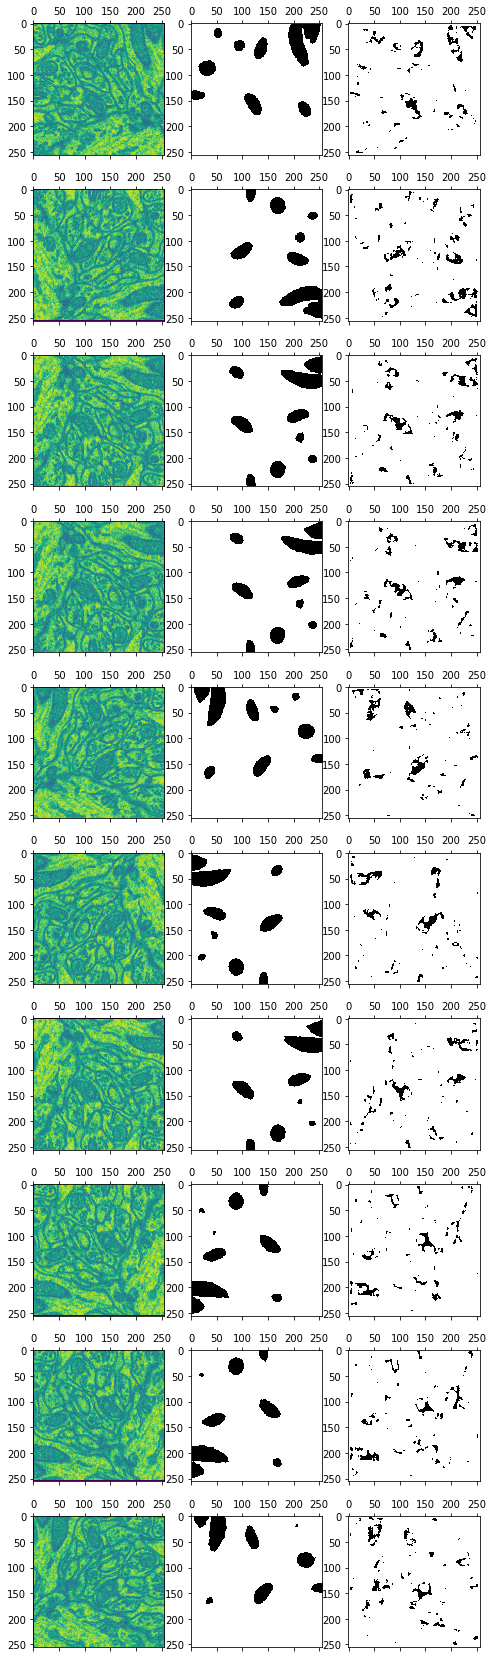

In [33]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  # No argmax - very different
  #ax[2].matshow(prediction[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

In [ ]:
# 1) Question
# TODO: Why do we use the prediction[0].argmax(axis=-1) command
# to display the prediction?
# 
# TODO: YOUR ANSWER
# Displaying the prediction without argmax (as in the commented-out code above)
# shows grayscale interstitial regions in the form of lines - which seem to line
# up with where the membranes in the original images to be.
# Calling argmax() on the predictions leaves only the regions in black - that
# is, the regions which were predicted with most confidence
# to be mitochondria, based on comparison to actual maps.

In [ ]:
# 2) Question
# TODO: Is the quality of the segmentation good and how could we improve it?
# Hint: Think along the lines of some traditional image processing rather than
# increasing the training data size.
#
# TODO: YOUR ANSWER
# No, the quality is not great - the images do not come out with rounded edges.
# One way to improve the image segmentation might be to boost the contrast
# on the imput image data sets, and/or dial down the green in the images leaving
# the red and blue channels intact. That seems to me like it would show the
# mitochondria more clearly.

**Bonus**: Compare against the state-of-the-art literature! [33 Points]

In [ ]:
#
# The following paper also uses a 2D U-Net to detect mitochondria:
# 
# https://danielhaehn.com/papers/?casser2020fast
#

In [ ]:
# 1) Question
#
# TODO: How many learnable parameters does your trained unet_model have?
# Hint: You can use TF's Model Summary function to answer this.
#

In [34]:
# TODO: YOUR CODE
unet_model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_block (ConvBlock)          (None, None, None, 6 37568       inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv_block[0][0]                 
__________________________________________________________________________________________________
conv_block_1 (ConvBlock)        (None, None, None, 1 221440      max_pooling2d[0][0]              
_______________________________________________________________________________________________

In [ ]:
# Our unet model has a total of 31,030,658 trainable parameters.

In [35]:
# 2) Question
#
# TODO: How many parameters do Casser et al. use?
#
print(1178480 + 780053)

1958533


In [ ]:
# TODO: YOUR ANSWER
# Casser et al. use 1,178,480 parameters for encoding and 780,053 for decoding,
# for a total of 1,958,533 trainable parameters.


In [ ]:
# 3) Question
#
# TODO: How did Casser et al. reduce the parameters?
#

In [ ]:
# TODO: YOUR ANSWER
# They reduced the use of convolution, which required parameters to train the
# filters. For decoding, they used upsampling layers instead, which did not
# rely on trainable parameters.

In [ ]:
# 4) Question
#
# TODO: Why did Casser et al. reduce the parameters?
#

In [ ]:
# TODO: YOUR ANSWER
# Training that many parameters is computationally expensive. It will take
# much less time to calculate losses if you can achieve a 20x reduction in the
# number of parameters, as the team did.

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#